100%|██████████| 169001437/169001437 [00:04<00:00, 35146484.54it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


model.safetensors:   0%|          | 0.00/50.3M [00:00<?, ?B/s]

Optimizer: SGD, Epoch [1/5], Loss: 4.6035
Optimizer: SGD, Epoch [2/5], Loss: 4.5842
Optimizer: SGD, Epoch [3/5], Loss: 4.5602
Optimizer: SGD, Epoch [4/5], Loss: 4.5448
Optimizer: SGD, Epoch [5/5], Loss: 4.5151
Optimizer: Adam, Epoch [1/5], Loss: 3.9489
Optimizer: Adam, Epoch [2/5], Loss: 2.3537
Optimizer: Adam, Epoch [3/5], Loss: 1.7653
Optimizer: Adam, Epoch [4/5], Loss: 1.5486
Optimizer: Adam, Epoch [5/5], Loss: 1.4313
Optimizer: RMSprop, Epoch [1/5], Loss: 3.8250
Optimizer: RMSprop, Epoch [2/5], Loss: 2.3062
Optimizer: RMSprop, Epoch [3/5], Loss: 1.7502
Optimizer: RMSprop, Epoch [4/5], Loss: 1.5650
Optimizer: RMSprop, Epoch [5/5], Loss: 1.4423
Optimizer: AdamW, Epoch [1/5], Loss: 3.8385
Optimizer: AdamW, Epoch [2/5], Loss: 2.2312
Optimizer: AdamW, Epoch [3/5], Loss: 1.7077
Optimizer: AdamW, Epoch [4/5], Loss: 1.5060
Optimizer: AdamW, Epoch [5/5], Loss: 1.4041
Optimizer: Adagrad, Epoch [1/5], Loss: 4.5854
Optimizer: Adagrad, Epoch [2/5], Loss: 4.5611
Optimizer: Adagrad, Epoch [3/5], 

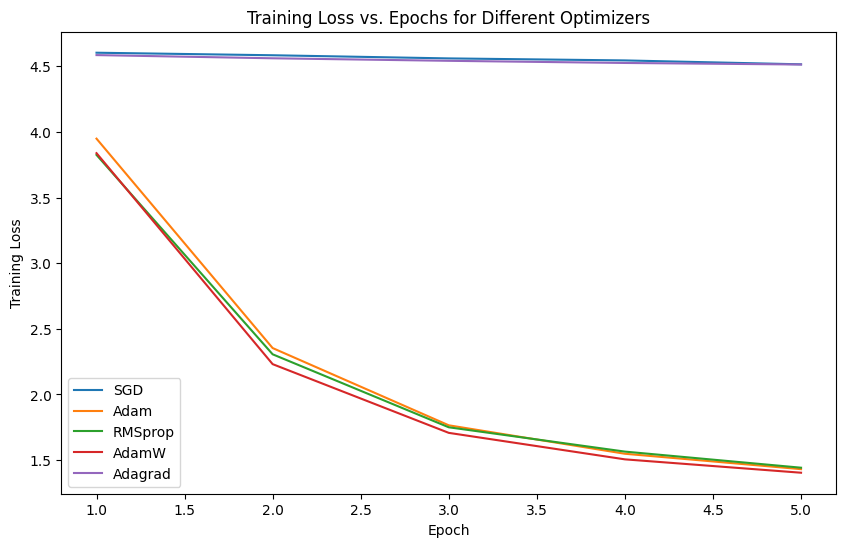

In [1]:
import torch
import timm
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from timm.data import create_dataset, create_loader
from timm.data.transforms_factory import create_transform

# 1. Load CIFAR-100 dataset via timm's create_dataset
train_dataset = create_dataset('torch/cifar100', root='./data', download=True, split='train')
test_dataset = create_dataset('torch/cifar100', root='./data', download=True, split='validation')

# Define transformations and data loaders
transform = create_transform(input_size=224, is_training=True)
train_dataset.transform = transform
test_dataset.transform = create_transform(input_size=224, is_training=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define different optimizers to test
optimizers = {
    'SGD': lambda params: optim.SGD(params, lr=0.0001, momentum=0.9),
    'Adam': lambda params: optim.Adam(params, lr=0.0001),
    'RMSprop': lambda params: optim.RMSprop(params, lr=0.0001),
    'AdamW': lambda params: optim.AdamW(params, lr=0.0001),
    'Adagrad': lambda params: optim.Adagrad(params, lr=0.0001),
}

results = {}

# Define loss function
criterion = nn.CrossEntropyLoss()

# 2. Loop through each optimizer
for opt_name, opt_func in optimizers.items():
    # Load the model for each optimizer
    model = timm.create_model('efficientvit_m5.r224_in1k', pretrained=True, num_classes=100)
    model.to(device)
    
    # Initialize the optimizer
    optimizer = opt_func(model.parameters())
    
    # Train the model for a few epochs and track loss only
    num_epochs = 5  # Short training for comparison purposes
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)  # Accumulate loss for the batch
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
        
        # Calculate and store average loss for this epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        print(f"Optimizer: {opt_name}, Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Store the loss results for each optimizer
    results[opt_name] = train_losses

# 3. Plotting the results
plt.figure(figsize=(10, 6))

# Plot Training Loss
for opt_name, losses in results.items():
    plt.plot(range(1, num_epochs + 1), losses, label=opt_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epochs for Different Optimizers")
plt.legend()

plt.show()
